# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

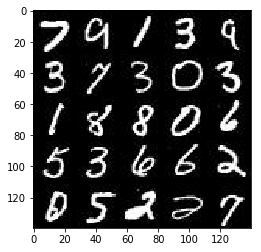

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

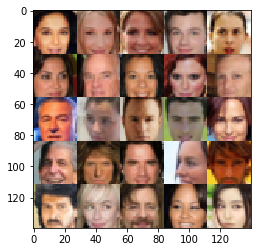

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        images = tf.image.resize_images(images, (32, 32))
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256        

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)

        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3
        
        logits = tf.image.resize_images(logits, (28, 28))
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Scale batch images from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, len(data_image_mode), data_image_mode)

    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator')
    pyplot.plot(losses.T[1], label='Generator')
    pyplot.title("Training Losses")
    pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1690... Generator Loss: 2.3101
Epoch 1/2... Discriminator Loss: 1.8542... Generator Loss: 3.8825
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 7.3802
Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 2.7093
Epoch 1/2... Discriminator Loss: 0.1433... Generator Loss: 2.9463
Epoch 1/2... Discriminator Loss: 0.1997... Generator Loss: 5.0372
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 6.2279
Epoch 1/2... Discriminator Loss: 0.4306... Generator Loss: 2.1552
Epoch 1/2... Discriminator Loss: 0.6032... Generator Loss: 3.6139
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.3704


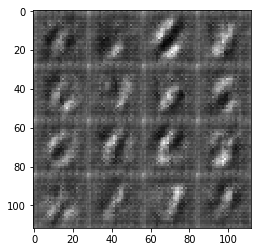

Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 1.1029
Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 1.3055
Epoch 1/2... Discriminator Loss: 2.0478... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 1.7105
Epoch 1/2... Discriminator Loss: 0.5648... Generator Loss: 1.9405
Epoch 1/2... Discriminator Loss: 0.4846... Generator Loss: 1.6306
Epoch 1/2... Discriminator Loss: 0.4087... Generator Loss: 2.8303
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 1.3810
Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 2.4639
Epoch 1/2... Discriminator Loss: 0.4038... Generator Loss: 2.3935


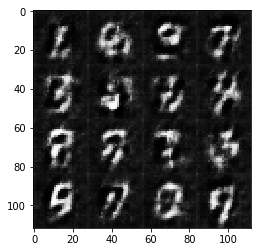

Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 1.7684
Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 2.8403
Epoch 1/2... Discriminator Loss: 0.3832... Generator Loss: 1.7494
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.9615
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 1.9608
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 2.7390
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 2.6608
Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 2.8181


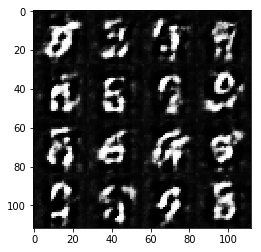

Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 2.7800
Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 2.3627
Epoch 1/2... Discriminator Loss: 0.3045... Generator Loss: 2.1439
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 1.9057
Epoch 1/2... Discriminator Loss: 0.3569... Generator Loss: 2.1515
Epoch 1/2... Discriminator Loss: 0.3585... Generator Loss: 1.9783
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 2.0862
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 2.3762
Epoch 1/2... Discriminator Loss: 0.4330... Generator Loss: 3.2399
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 1.5426


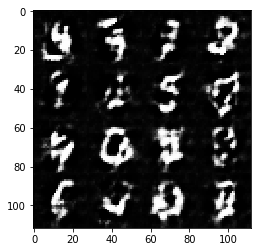

Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 2.0523
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 1.9070
Epoch 1/2... Discriminator Loss: 0.3687... Generator Loss: 2.3978
Epoch 1/2... Discriminator Loss: 0.4546... Generator Loss: 1.4210
Epoch 1/2... Discriminator Loss: 0.5067... Generator Loss: 1.2250
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 1.1939
Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 2.4420
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 2.0181
Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 3.0205


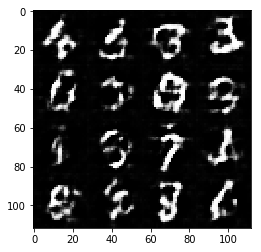

Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 0.2659... Generator Loss: 3.1896
Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 0.6336... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 2.0238
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 4.3632
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 2.6885
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 0.3532... Generator Loss: 2.1308


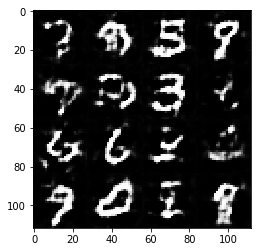

Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 2.1303
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 3.0825
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 1.2393
Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 1.2771
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 3.2012
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 0.3161... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 0.4609... Generator Loss: 1.4240
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.6902


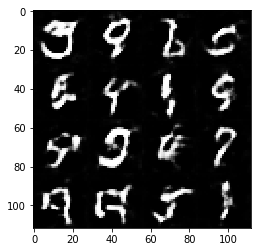

Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 1.2924
Epoch 1/2... Discriminator Loss: 3.0111... Generator Loss: 0.1250
Epoch 1/2... Discriminator Loss: 0.6713... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 1.7733
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 1.7122
Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 1.5897
Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 2.2306
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 1.2230
Epoch 1/2... Discriminator Loss: 0.5132... Generator Loss: 1.3919


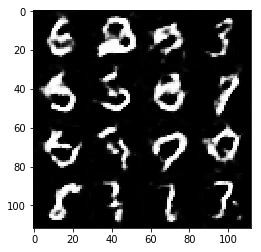

Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 5.0550
Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 2.2009
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 1.6972
Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 1.9640
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 1.8619
Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 1.6380
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.1059
Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 2.0028
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 1.3034


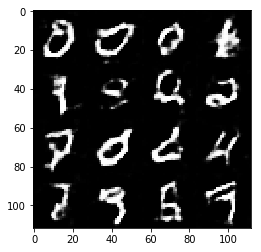

Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 2.2529
Epoch 1/2... Discriminator Loss: 0.4140... Generator Loss: 2.7796
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 1.6756
Epoch 2/2... Discriminator Loss: 0.5392... Generator Loss: 1.1514
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.2041
Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 1.4716
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.0489
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 0.8442


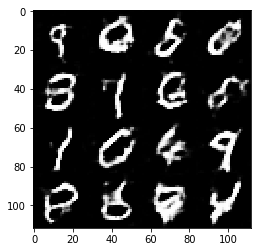

Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 1.7196
Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 1.7261
Epoch 2/2... Discriminator Loss: 0.3347... Generator Loss: 1.9228
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.3901
Epoch 2/2... Discriminator Loss: 0.3116... Generator Loss: 1.8686
Epoch 2/2... Discriminator Loss: 0.3902... Generator Loss: 1.9737
Epoch 2/2... Discriminator Loss: 0.3424... Generator Loss: 1.8713
Epoch 2/2... Discriminator Loss: 0.4048... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 1.6408


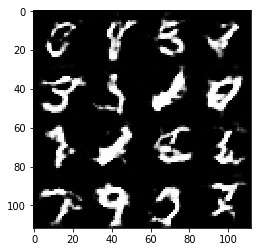

Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 1.8290
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 1.3007
Epoch 2/2... Discriminator Loss: 1.0436... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.0106
Epoch 2/2... Discriminator Loss: 0.5725... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.2920
Epoch 2/2... Discriminator Loss: 0.4596... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 1.9704
Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 1.2467
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 1.5545


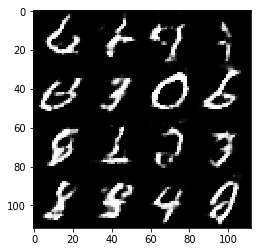

Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 1.4574
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 0.5522... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.3243
Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 0.3213... Generator Loss: 1.8862
Epoch 2/2... Discriminator Loss: 3.5192... Generator Loss: 0.0759
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.9923
Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 0.7092


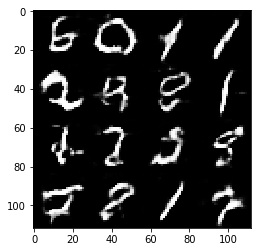

Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 0.3421... Generator Loss: 2.1018
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 1.2793
Epoch 2/2... Discriminator Loss: 0.4969... Generator Loss: 1.2808
Epoch 2/2... Discriminator Loss: 0.4338... Generator Loss: 2.6013
Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 0.9992
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.2521
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 0.6062... Generator Loss: 1.2039


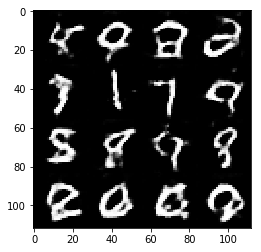

Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 1.2296
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 1.4538
Epoch 2/2... Discriminator Loss: 0.4974... Generator Loss: 1.3215
Epoch 2/2... Discriminator Loss: 0.4459... Generator Loss: 1.5335
Epoch 2/2... Discriminator Loss: 0.3072... Generator Loss: 1.7436
Epoch 2/2... Discriminator Loss: 0.4162... Generator Loss: 1.5565
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 0.4359... Generator Loss: 1.5040
Epoch 2/2... Discriminator Loss: 2.2513... Generator Loss: 4.6923
Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 1.8919


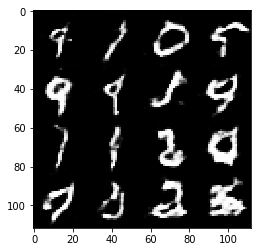

Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.2530
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 0.6391... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 1.2124
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.4560
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 0.4610... Generator Loss: 1.4767
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 1.4095
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.1599


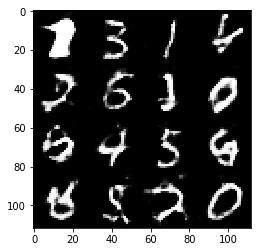

Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 1.4451
Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 1.8864
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 0.4145... Generator Loss: 1.6837
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 2.6208
Epoch 2/2... Discriminator Loss: 0.3955... Generator Loss: 1.7030
Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 1.5510


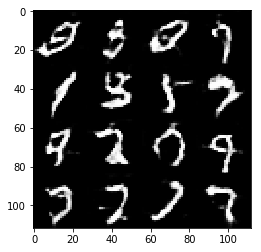

Epoch 2/2... Discriminator Loss: 0.3066... Generator Loss: 1.7999
Epoch 2/2... Discriminator Loss: 0.4923... Generator Loss: 1.3041
Epoch 2/2... Discriminator Loss: 0.4311... Generator Loss: 1.4204
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 1.7564
Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 2.2874
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 2.1876
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.5504... Generator Loss: 1.6380
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.3874


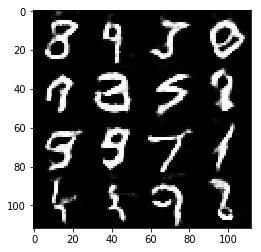

Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.2942
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 1.2036
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 1.7033
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 1.5760
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.2869
Epoch 2/2... Discriminator Loss: 0.4560... Generator Loss: 2.0933


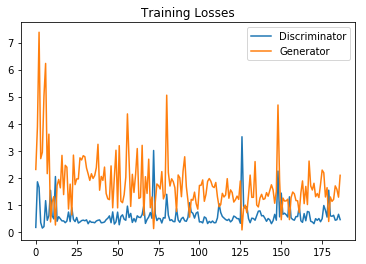

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 2.1615
Epoch 1/1... Discriminator Loss: 0.2511... Generator Loss: 2.4502
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 1.7526
Epoch 1/1... Discriminator Loss: 2.5413... Generator Loss: 0.1704
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 3.8667
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 1.9742
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.9396
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 1.9411


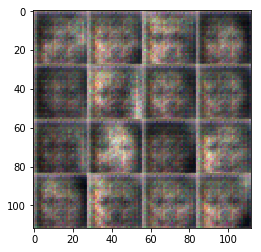

Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 4.3028
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.3245
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 4.6219
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.8549
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 4.0130
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.8333


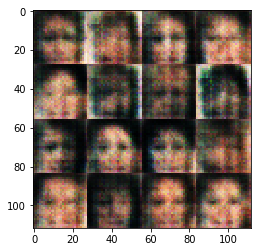

Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 2.2426
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 2.4380
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.9779
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 2.3435
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 3.9918
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.8545


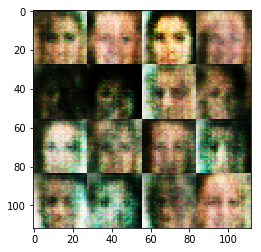

Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 2.0459
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 2.7260
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 2.4294
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.0667


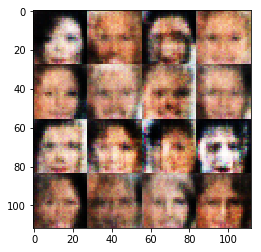

Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 2.8302
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.6754


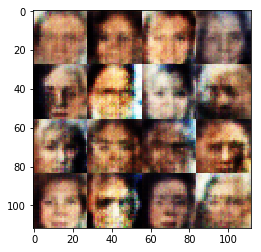

Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.8310
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.7210
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 2.3668
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.5015


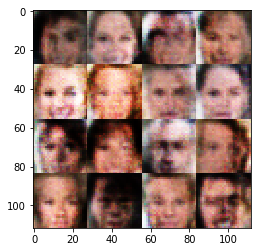

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 2.1218
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 0.9873


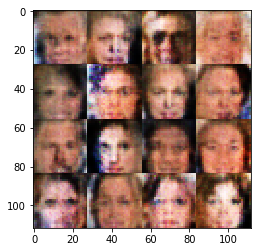

Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 2.3643
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 2.1640
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.4501


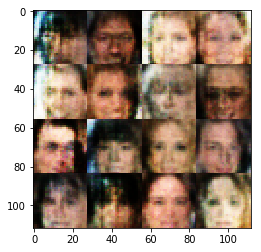

Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.6658
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.5495
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.3373


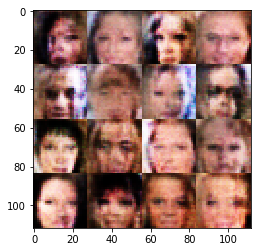

Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.7584
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 0.7918


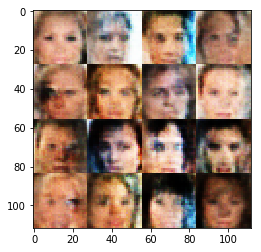

Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 2.4436
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.3976


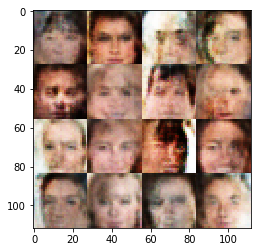

Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.6953
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 2.2795
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.9668
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 0.9608


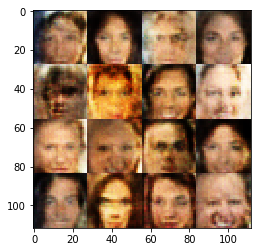

Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.9323
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.9522
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.1041


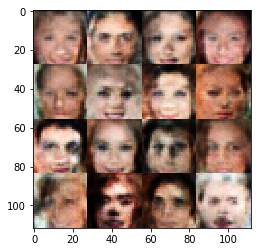

Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.5918
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.7136
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.3419
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.9655


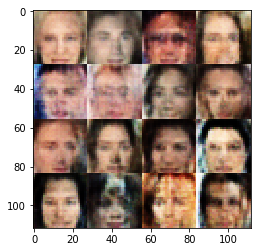

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 2.6341
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.3274
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.8985
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.5727


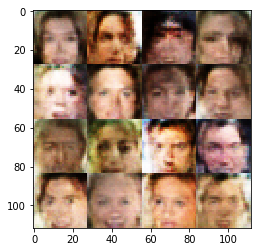

Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 0.8734


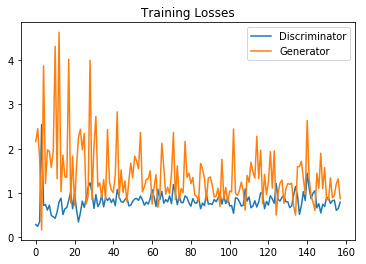

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.